In [1]:
#!/usr/bin/env python3

################################
# Scientific imports
################################
import matplotlib.pyplot as plt
import numpy as np

from astroquery.mast import Observations
from astroquery.mast import Catalogs

from astropy.table import Table
from astropy.table import QTable
from astropy.io import fits
from astropy import units as u
from astropy.timeseries import BoxLeastSquares
from astropy.timeseries import TimeSeries
from astropy.stats import sigma_clipped_stats
from astropy.timeseries import aggregate_downsample

import lightkurve as lk

################################
# General imports
################################
import csv, math, io, os, os.path, sys, random, time, json, gc
from datetime import datetime
import pandas as pd
import seaborn as sb
from collections import Counter

################################
# Suppress Warnings
################################
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

################################
# Initialisers
################################
plt.rcParams["figure.figsize"] = (16,5)
sb.set()

# Load the Data files
fitsarr = np.load("fitslist.npy")

In [2]:
################################
# Functions
################################

def LoadList():
    
    planet_list ="tsop301_planet_data.txt"
    star_list   ="tsop301_star_data.txt"
    eb_list     ="tsop301_eb_data.txt"
    beb_list    ="tsop301_backeb_data.txt"
    
    starlist = LoadListGeneral(star_list)
    planetlist = LoadListGeneral(planet_list)
    eblist = LoadListGeneral(eb_list)
    beblist = LoadListGeneral(beb_list)
    
    alllists = {"s": starlist, "p": planetlist, "eb": eblist, "beb": beblist}
    
    return alllists

def LoadListGeneral(f):
    
    lst=[]
    try:
        # Assuming everything CAN go well, do this
        with open('./SIM_DATA/unpacked/{}'.format(f)) as df:
            csvdf = csv.reader(df)
            for lineholder in csvdf:
                line = lineholder[0]                # 'lineholder' is a list, 1 element long, containing only a single string
                if line[0]!="#":                    # Ignore commented lines (lines w/ FIRST STRING ELEMENT is a # character)
                    lst.append(line.split()[0])     # Add line to list
                # endif
            # endfor
        # endwith
    except FileNotFoundError:
        print("FNF")
        return
    # end try
    
    return lst


# Python3 implementation to find elements
# that appeared only once
# Function to find the elements that
# appeared only once in the array
def OccurredOnce(in_arr, out_arr, count=1):
    
    n = len(in_arr)
    #counting frequency of every element using Counter
    mp=Counter(in_arr)
    # Traverse the map and print all
    # the elements with occurrence 1
    for it in mp:
        if mp[it] == count:
            out_arr.append(int(it))
            #print(it, end = " ")
    return


def MakeTimeSeries(L, f, binSize=0.2, timedBinSize=0.001):
    
    global C
    C = C+1
    print("Processing File {} of {}...".format(C,L))
    
    ts = TimeSeries.read(fitsarr[int(f)], format='tess.fits')
    periodogram = BoxLeastSquares.from_timeseries(ts, 'sap_flux')
    results = periodogram.autopower(binSize * u.day)  
    best = np.argmax(results.power)  
    period = results.period[best]
    transit_time = results.transit_time[best]
    ts_folded = ts.fold(period=period, epoch_time=transit_time)
    mean, median, stddev = sigma_clipped_stats(ts_folded['sap_flux'])
    ts_folded['sap_flux_norm'] = ts_folded['sap_flux'] / median
    ts_binned = aggregate_downsample(ts_folded, time_bin_size=timedBinSize * u.day)
    
    return(ts_binned['sap_flux_norm'].value)

def GetTICListOfOnlyZeroOrOneExoplanets(fname):
    
    master_list = LoadList()
    starList, planetList, ebList, bebList = master_list['s'], master_list['p'], master_list['eb'], master_list['beb']
    starList   = [int(x) for x in starList]
    planetList = [int(x) for x in planetList]
    ebList     = [int(x) for x in ebList]
    bebList    = [int(x) for x in bebList]
    
    TICList=list(np.load("TICList.npy"))
    print("TICList is {} entries long".format(len(TICList)))
    
    #####################
    
    one_planet_lcs = []
    lst_a = one_planet_lcs
    
    OccurredOnce(planetList, one_planet_lcs)
    
    #####################
    
    fLen = len(fluxarr)
#    print("The file '{}' contains a list of {} LCs!".format(fname,fLen))
    
    zero_or_one_exoplanets = list(set(starList + one_planet_lcs))
    zero_or_one_exoplanets.sort()
    
    flist = [TICList.index(zero_or_one_exoplanets[x]) for x in range(len(zero_or_one_exoplanets))]
    print("FList has {} entries".format(len(flist)))
    
    # 'flist' now contains a list of file indices of the FITS files that contain Zero or One exoplanet.
    
    np.save(fname,flist)

def MakeTimeSeries(f, binSize=0.2, timedBinSize=0.003, numbins=None):
    
    ts = TimeSeries.read(fitsarr[int(f)], format='tess.fits')
    periodogram = BoxLeastSquares.from_timeseries(ts, 'sap_flux')
    results = periodogram.autopower(binSize * u.day)  
    best = np.argmax(results.power)  
    period = results.period[best]
    transit_time = results.transit_time[best]
    ts_folded = ts.fold(period=period, epoch_time=transit_time)
    mean, median, stddev = sigma_clipped_stats(ts_folded['sap_flux'])
    ts_folded['sap_flux_norm'] = ts_folded['sap_flux'] / median
    #ts_binned = aggregate_downsample(ts_folded, time_bin_size=timedBinSize * u.day, n_bins=numbins)
    
    # Delete unnecessary vars
    del ts, periodogram, period, results, best, transit_time, mean, median, stddev#, ts_folded
    
    #return(ts_folded['sap_flux_norm'].value)
    #return(ts_binned['sap_flux_norm'].value)
    return(ts_folded)

def MakeDataFrames(ts):
    print("")

In [3]:
# Define the column list
goodCols = ['time', 'sap_flux', 'sap_flux_err', 'pdcsap_flux', 'pdcsap_flux_err', 'sap_flux_norm']
badcols = ['timecorr','cadenceno','sap_bkg','sap_bkg_err','quality','psf_centr1','psf_centr1_err','psf_centr2','psf_centr2_err','mom_centr1','mom_centr1_err','mom_centr2','mom_centr2_err','pos_corr1','pos_corr2']

In [130]:
test_lc = MakeTimeSeries(0)
test_lc[0]

time,timecorr,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2,sap_flux_norm
,d,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix,
object,float32,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32
-0.12,3.9201858e-03,1091,1.6815347e+05,3.9126457e+01,1.2736135e+03,3.5170083e+00,0.0000000e+00,0.0000000e+00,1000,nan,nan,nan,nan,2078.83887,1.8392301e-04,1284.05174,2.0383555e-04,nan,nan,9.8280132e-01


In [119]:
type(test_lc)

astropy.timeseries.sampled.TimeSeries

In [83]:
# Numpy Load the NPY file
fname="TST_CSV.npy"
arrOfDfs = np.load(fname, allow_pickle=True)
len(arrOfDfs)

10

In [88]:
Q = arrOfDfs[1]
Q

array([[Timedelta('0 days 01:34:22.952781487'), 10343.4453125,
        10.479938507080078, 0.0, 0.0, 0.9927560687065125],
       [Timedelta('0 days 01:36:22.954692559'), 10363.7578125,
        10.487250328063965, 11841.5078125, 11.956857681274414,
        0.9947056770324707],
       [Timedelta('0 days 01:38:22.956623748'), 10337.75390625,
        10.473523139953613, 11830.53515625, 11.941205978393555,
        0.9922098517417908],
       ...,
       [Timedelta('-3 days +10:55:04.731915472'), 10358.978515625,
        10.502925872802734, 11841.0283203125, 11.97472858428955,
        0.9942469596862793],
       [Timedelta('-3 days +10:57:04.730909642'), 10386.6982421875,
        10.51721477508545, 11864.30859375, 11.991020202636719,
        0.9969074726104736],
       [Timedelta('-3 days +10:59:04.729923928'), 10360.4775390625,
        10.504563331604004, 0.0, 0.0, 0.9943908452987671]], dtype=object)

In [89]:
pd.DataFrame(Q, columns=goodCols)

,time,sap_flux,sap_flux_err,pdcsap_flux,pdcsap_flux_err,sap_flux_norm
0,0 days 01:34:22.952781487,10343.445312,10.479939,0.0,0.0,0.992756
1,0 days 01:36:22.954692559,10363.757812,10.48725,11841.507812,11.956858,0.994706
2,0 days 01:38:22.956623748,10337.753906,10.473523,11830.535156,11.941206,0.99221
3,0 days 01:40:22.958534820,10328.604492,10.469361,11864.753906,11.936461,0.991332
4,0 days 01:42:22.960445892,10345.121094,10.480734,11822.853516,11.949428,0.992917
...,...,...,...,...,...,...
20076,-3 days +10:51:04.733886899,10359.186523,10.500278,11835.231445,11.97171,0.994267
20077,-3 days +10:53:04.732901185,10354.700195,10.503828,11822.033203,11.975758,0.993836
20078,-3 days +10:55:04.731915472,10358.978516,10.502926,11841.02832,11.974729,0.994247
20079,-3 days +10:57:04.730909642,10386.698242,10.517215,11864.308594,11.99102,0.996907


In [46]:
Q = np.load("ZeroOrOneFoldedFluxes_TEST.npy",allow_pickle=True)
#Q = np.load("ZeroOrOneFoldedFluxes_4717bins.npy")

In [82]:
print(len(Q))

20081


In [48]:
idlist=[]
Qlens = [len(i) for i in Q]
L = np.max(Qlens)
mean = np.mean(Qlens)
std = np.std(Qlens)
print(L)
print(f"The mean length is {mean} with a std dev of {std}.")
for e,i in enumerate(Q):
    if len(i) == L:
        print(f"Line {e} has max length of {len(i)}")
        idlist.append(e)
idlist

4717
The mean length is 3564.5757046100066 with a std dev of 1390.7291640025542.
Line 3350 has max length of 4717
Line 3420 has max length of 4717
Line 5389 has max length of 4717
Line 6327 has max length of 4717
Line 6449 has max length of 4717
Line 7218 has max length of 4717
Line 7957 has max length of 4717
Line 8128 has max length of 4717
Line 8380 has max length of 4717


[3350, 3420, 5389, 6327, 6449, 7218, 7957, 8128, 8380]

In [12]:
foldedFluxes = [MakeTimeSeries(x) for x in idlist]

In [27]:
newfoldedFluxes = [MakeTimeSeries(x, numbins=2000) for x in idlist]

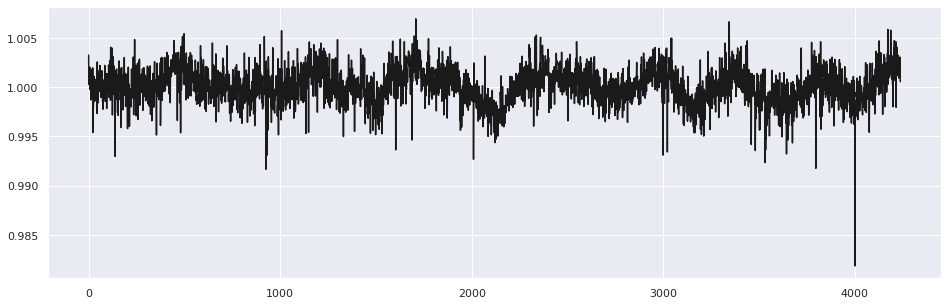

In [31]:
plt.plot(foldedFluxes[0], 'k-', markersize=1)

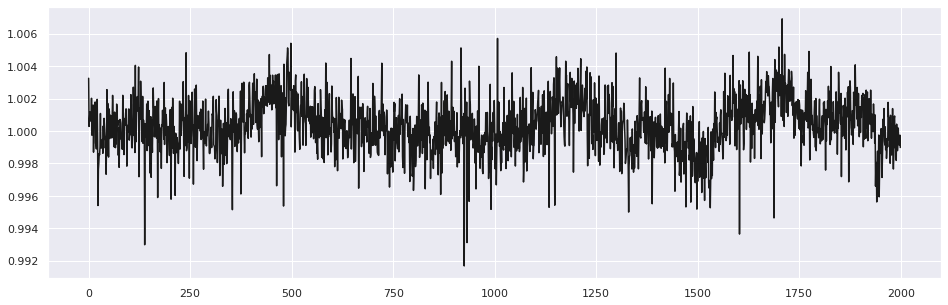

In [30]:
plt.plot(newfoldedFluxes[0], 'k-', markersize=1)

In [52]:
# FIX ANY NANS
def FixNans(Q):
    nanlist=[]
    nanpts =[]
    for i in range(len(Q)):
        if np.isnan(np.sum(Q[i])):
            #print(np.argwhere(np.isnan(foldedFluxes[i])))
            print("NaN detected at entry {} and datapoint {}".format(i,np.argwhere(np.isnan(Q[i]))))
            nanlist.append(i)
            nanpts.append(np.argwhere(np.isnan(Q[i]))[0][0])

    newnanlist = nanlist.copy()

    for n, i in enumerate(nanlist):
        e = nanpts[n]
        LB = nanpts[n]-1
        UB = nanpts[n]+1
        #print(Q[i])
        #print(Q[i][LB:UB])
        print(f"Turn ({Q[i][e]:.6f}) into average of ({Q[i][LB]:.6f}...) and ({Q[i][UB]:.6f}...)")
        ave = np.nanmean(Q[i][LB:UB+1])
        print(f"That makes {ave}!")
        Q[i][e] = ave1
    return(nanlist,nanpts)

In [91]:
Z = np.load("ZeroOrOneFoldedFluxes_TSLIST.npy")

In [8]:
QWERTY = pd.read_csv('./csv_files/Z_or_O_15196.zip')
QWERTY = QWERTY[1:-1]
QWERTY

,sap_flux,sap_flux_err,pdcsap_flux,pdcsap_flux_err,sap_flux_norm
1,9564.6760,10.157169,11040.260,11.808185,0.984663
2,9561.5120,10.159134,11031.376,11.810470,0.984337
3,9505.6780,10.133104,11019.371,11.780208,0.978589
4,9573.4670,10.158876,11046.069,11.810169,0.985568
5,9513.4000,10.136336,11006.865,11.783965,0.979384
...,...,...,...,...,...
20075,9699.3070,10.243904,11168.034,11.909019,0.998523
20076,9616.8810,10.204316,11066.908,11.862994,0.990037
20077,9602.7040,10.201479,11057.756,11.859696,0.988578
20078,9608.3125,10.198335,11062.790,11.856041,0.989155


In [17]:
lk.LightCurve.fold?
curve = lk.LightCurve(time=range(len(QWERTY)), flux=QWERTY['pdcsap_flux'])

Signature: lk.LightCurve.fold(self, period, t0=None, transit_midpoint=None)
Docstring:
Folds the lightcurve at a specified `period` and reference time `t0`.

This method returns a `~lightkurve.lightcurve.FoldedLightCurve` object
in which the time values range between -0.5 to +0.5 (i.e. the phase).
Data points which occur exactly at ``t0`` or an integer multiple of
``t0 + n*period`` will have phase value 0.0.

Examples
--------
The example below shows a light curve with a period dip which occurs near
time value 1001 and has a period of 5 days. Calling the `fold` method
will transform the light curve into a
`~lightkurve.lightcurve.FoldedLightCurve` object::

    >>> import lightkurve as lk
    >>> lc = lk.LightCurve(time=range(1001, 1012), flux=[0.5, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.5])
    >>> folded_lc = lc.fold(period=5., t0=1006.)
    >>> folded_lc   # doctest: +SKIP
    <lightkurve.lightcurve.FoldedLightCurve>

An object of type `~lightkurve.lightcurve.FoldedLightCurve

<AxesSubplot:xlabel='Time', ylabel='Flux'>

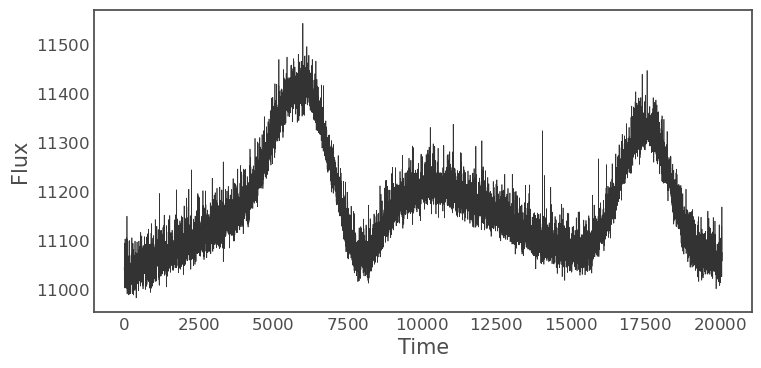

In [25]:
curve.plot(markersize=1)

In [20]:
foldedcurve = curve.bin()

<AxesSubplot:xlabel='Time', ylabel='Flux'>

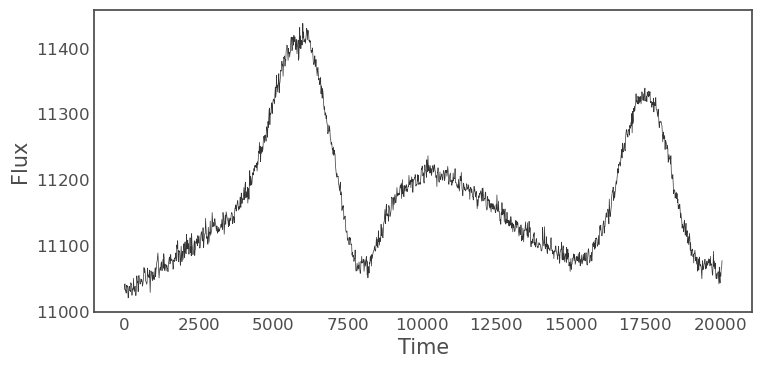

In [24]:
foldedcurve.plot(markersize=1)

In [26]:
len(curve)

20079

In [27]:
len(foldedcurve)

1544